### XGBoost Model

Training complete!


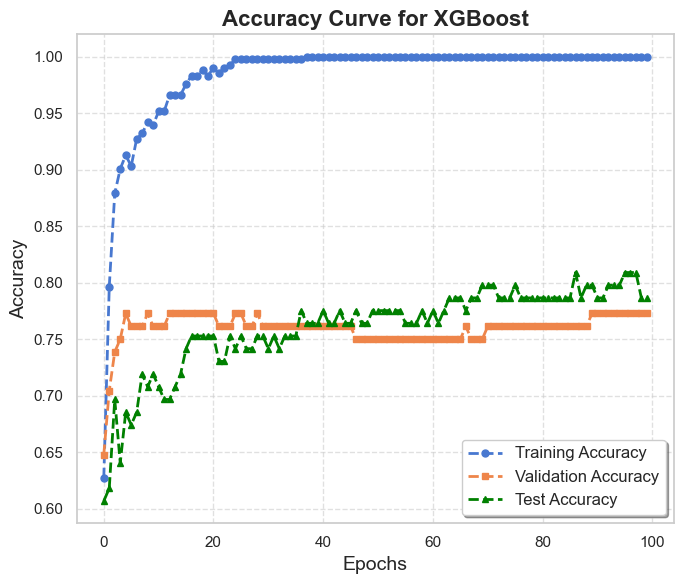

Final Test Accuracy: 0.7865
Final Test ROC AUC: 0.8277


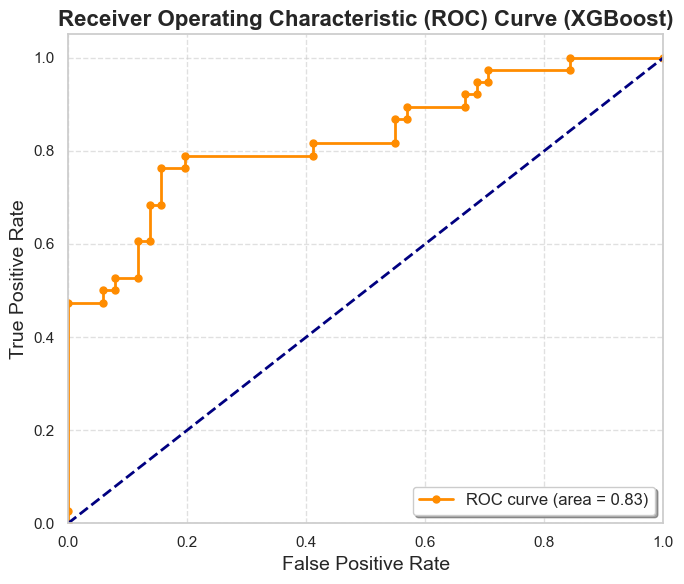

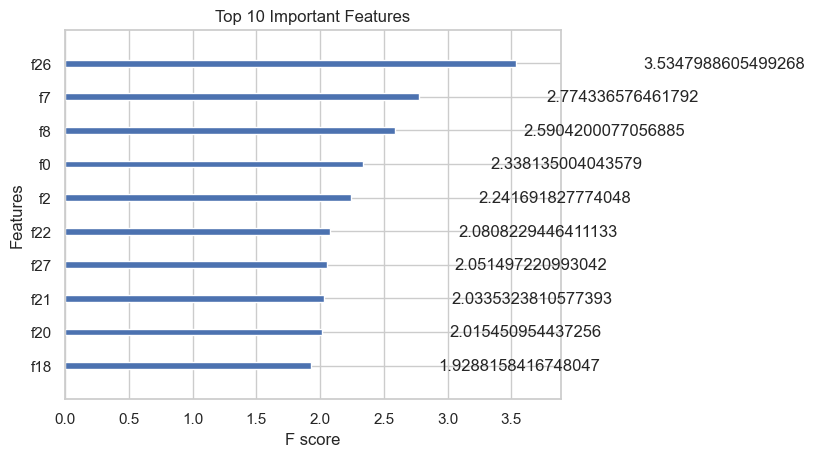

In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb 
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
def load_data(directory, cell_type):
    position_data = []
    velocity_data = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, filename))
            position = df[['X', 'Y', 'Z']].values
            velocity = df[['velocity_x', 'velocity_y', 'velocity_z']].values
            position_data.append(position)
            velocity_data.append(velocity)
            labels.append(cell_type)
    return position_data, velocity_data, labels

# Load PLT and WBC data
soft_position, soft_velocity, soft_labels = load_data('D:/Assessment/PINN/LSTM-Problem/NewTimeSeriesDataForCells/soft_dir', 0)
rigid_position, rigid_velocity, rigid_labels = load_data('D:/Assessment/PINN/LSTM-Problem/NewTimeSeriesDataForCells/hard_dir', 1)

# Combine data and labels
all_position_data = soft_position + rigid_position
all_velocity_data = soft_velocity + rigid_velocity
all_labels = soft_labels + rigid_labels

# Function to extract features from sequences
def extract_features(position_data, velocity_data):
    features = []
    for pos, vel in zip(position_data, velocity_data):
        feature = []
        for axis in range(pos.shape[1]):  # Iterate over X, Y, Z axes
            feature.extend([
                np.mean(pos[:, axis]), np.std(pos[:, axis]), np.min(pos[:, axis]), np.max(pos[:, axis]), np.median(pos[:, axis]),
                np.mean(vel[:, axis]), np.std(vel[:, axis]), np.min(vel[:, axis]), np.max(vel[:, axis]), np.median(vel[:, axis])
            ])
        features.append(feature)
    return np.array(features)

# Extract features
X = extract_features(all_position_data, all_velocity_data)
y = np.array(all_labels)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize lists to store accuracy for each epoch
train_acc = []
val_acc = []
test_acc = []

num_epochs = 100  # Set the number of epochs

# Convert data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.1,
}

# Train the model for multiple epochs
for epoch in range(num_epochs):
    model = xgb.train(params, dtrain, num_boost_round=1, xgb_model=model if epoch > 0 else None)

    # Predict probabilities
    y_train_pred_prob = model.predict(dtrain)
    y_val_pred_prob = model.predict(dval)
    y_test_pred_prob = model.predict(dtest)

    # Convert probabilities to binary predictions (threshold = 0.5)
    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)

    # Calculate and store accuracy
    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

print("Training complete!")

# Assuming you have train_acc, val_acc, and test_acc already defined as lists
# Apply seaborn style and color palette
sns.set(style="whitegrid")
colors = sns.color_palette("muted")

# Plotting the accuracy curves
plt.figure(figsize=(7, 6))

plt.plot(train_acc, label='Training Accuracy', color=colors[0], linestyle='--', linewidth=2, marker='o', markersize=5)
plt.plot(val_acc, label='Validation Accuracy', color=colors[1], linestyle='--', linewidth=2, marker='s', markersize=5)
plt.plot(test_acc, label='Test Accuracy', color='green', linestyle='--', linewidth=2, marker='^', markersize=5)

# Add titles and labels with formatting
plt.title('Accuracy Curve for XGBoost', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Add legend with formatting
plt.legend(fontsize=12, shadow=True)

# Customize grid
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better appearance
plt.tight_layout()

# Display the plot
plt.show()


# Evaluate the final model on the test set
y_test_pred = (model.predict(dtest) > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, model.predict(dtest))

print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test ROC AUC: {test_roc_auc:.4f}")

# Plot for ROC curve
y_test_prob = model.predict(dtest)
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))

# Apply seaborn style and color palette
sns.set(style="whitegrid")
colors = sns.color_palette("muted")

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})', marker='o', markersize=5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve (XGBoost)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Feature importance plot
xgb.plot_importance(model, max_num_features=10, importance_type='gain', title='Top 10 Important Features')
plt.show()
